In [1]:
# Inputs
imageDownloadUrl = 'https://discourse-cloud-file-uploads.s3.dualstack.us-west-2.amazonaws.com/business4/uploads/imagej/original/3X/f/f/ff8e0733c105dbc9e758203efa5684c74edcfdfe.tif'
thresholdMin = 31700
thresholdMax = 35000
thresholdStep = 100

In [2]:
import JupyterNotebooksLib as slicernb
import slicer

# Set viewer size to 50% of screen size
slicernb.AppWindow.setWindowSize(scale=0.5)
# Hide patient information from slice view
slicernb.showSliceViewAnnotations(False)

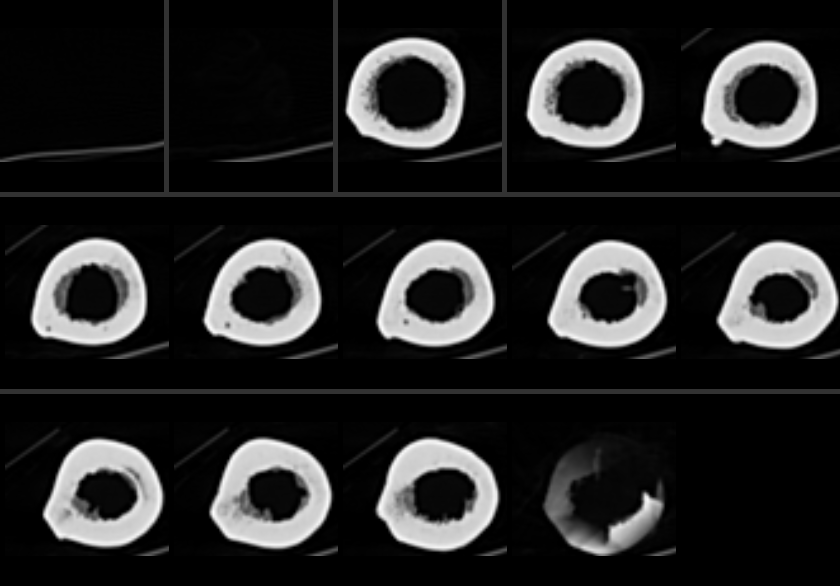

In [3]:
# Clear the workspace
slicer.mrmlScene.Clear()

# Load input image
import SampleData
volumeNode = slicer.util.loadVolume(SampleData.downloadFromURL(fileNames='8021D.tif', uris=imageDownloadUrl)[0])

# Lightbox view
slicernb.ViewLightboxDisplay("Red", columns=5, rows=3)

Threshold=31700


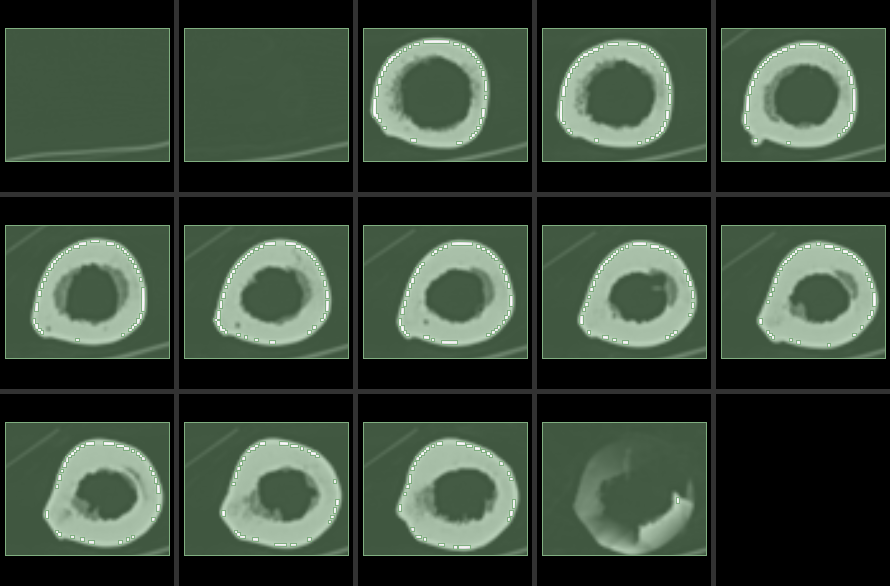

Threshold=31800


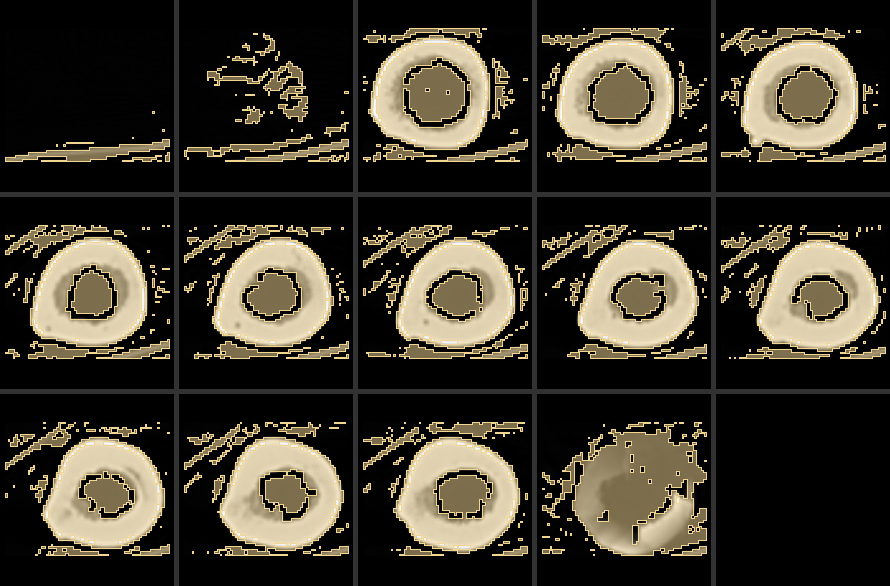

Threshold=31900


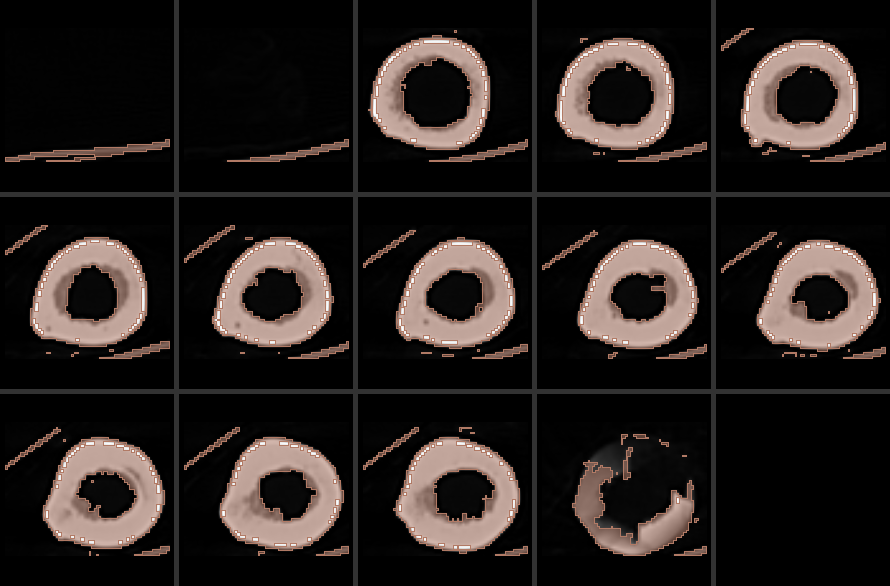

Threshold=32000


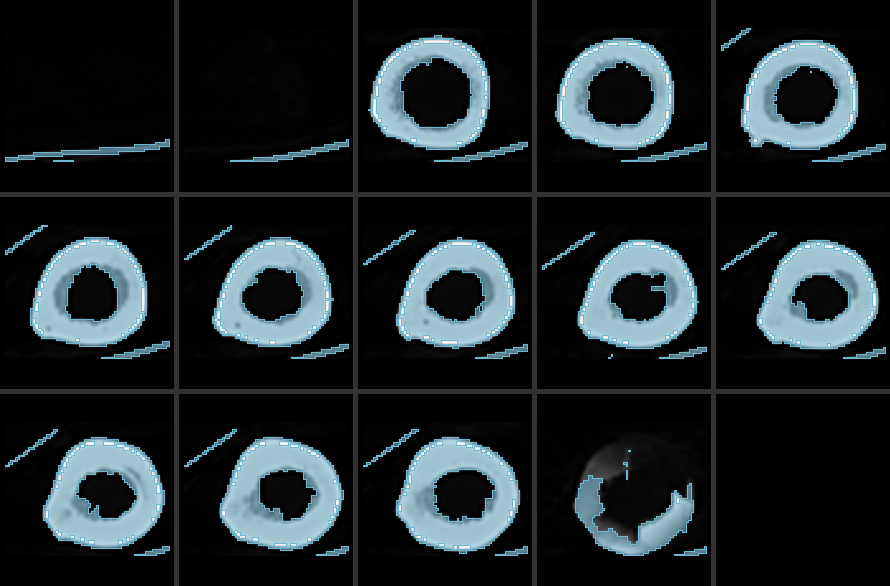

Threshold=32100


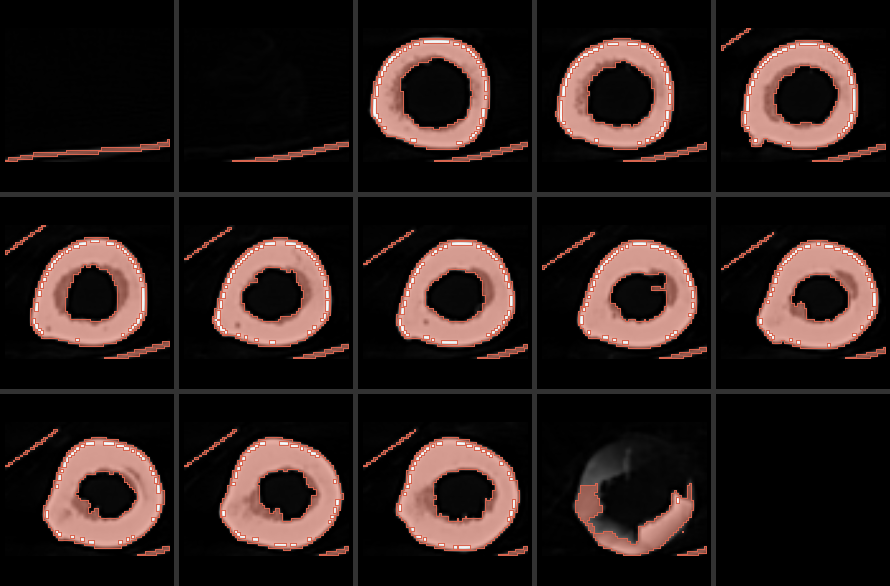

Threshold=32200


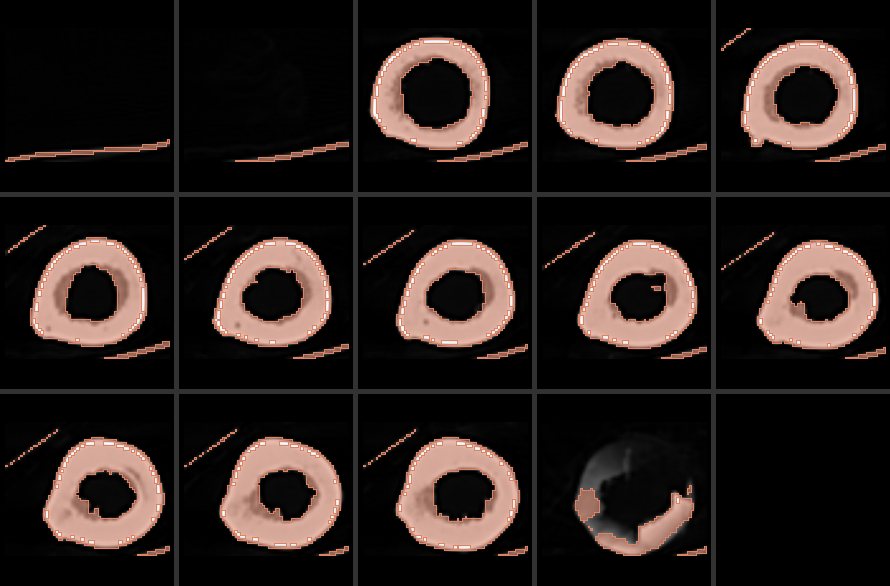

Threshold=32300


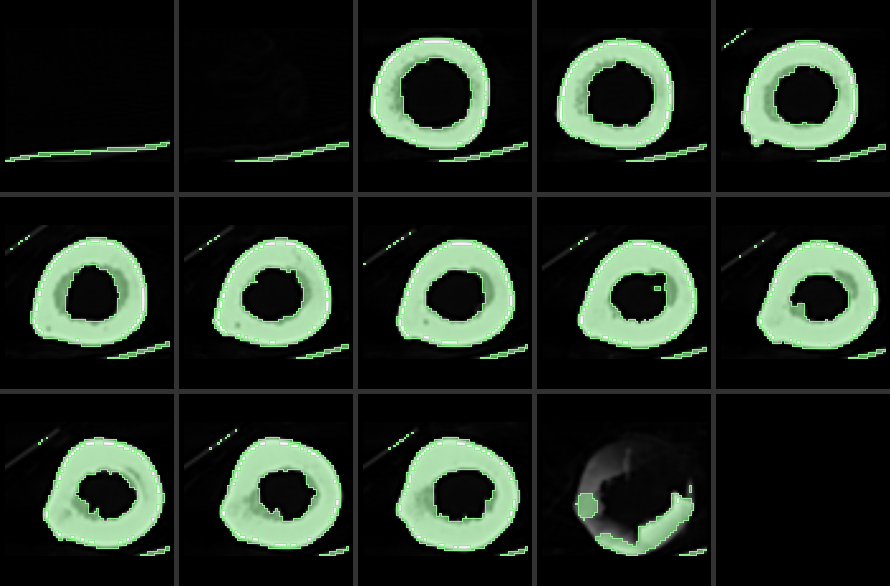

Threshold=32400


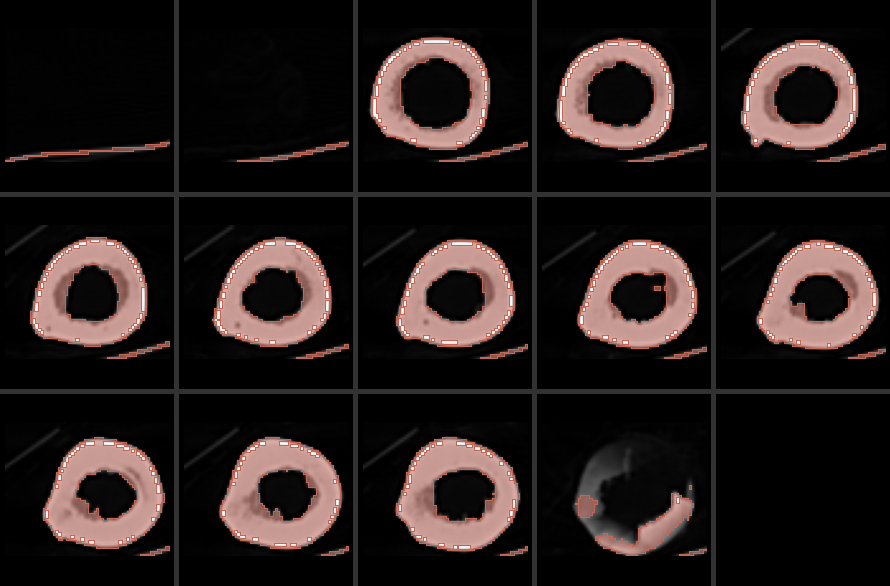

Threshold=32500


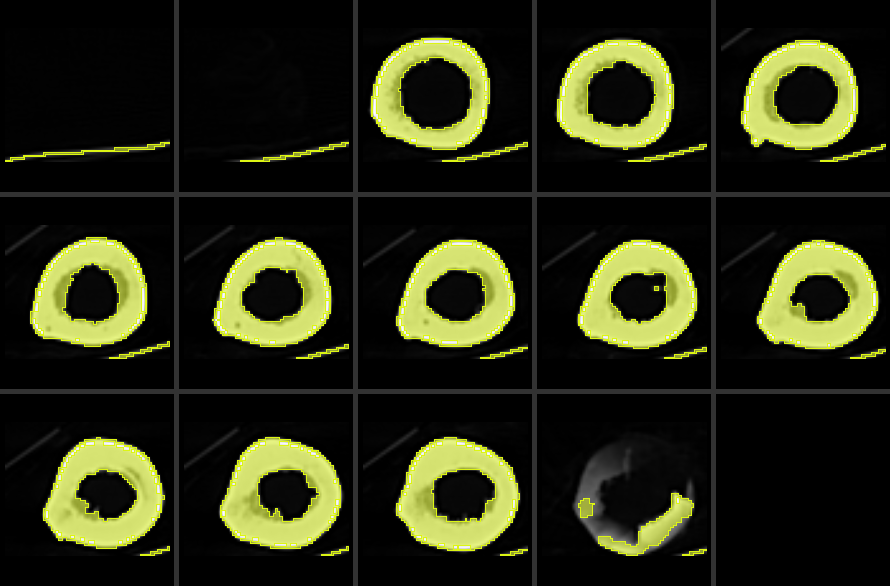

Threshold=32600


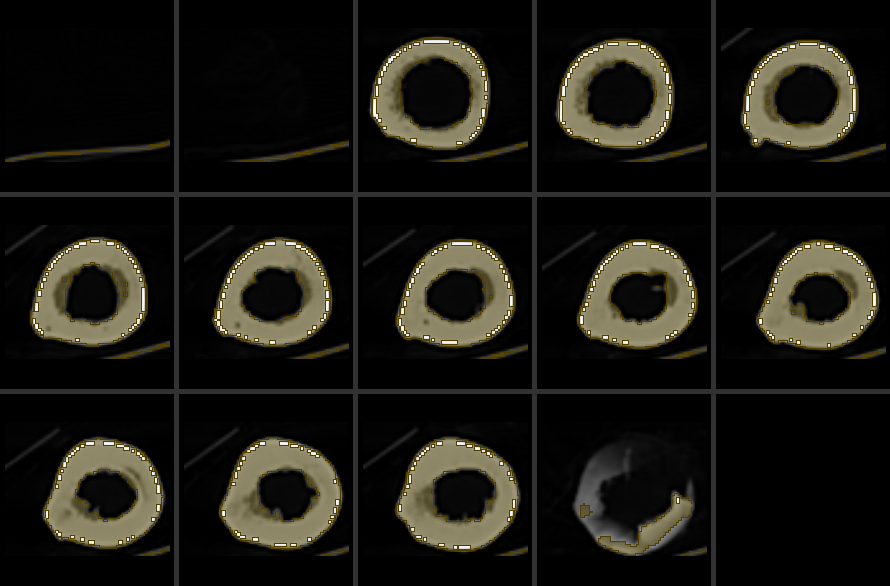

Threshold=32700


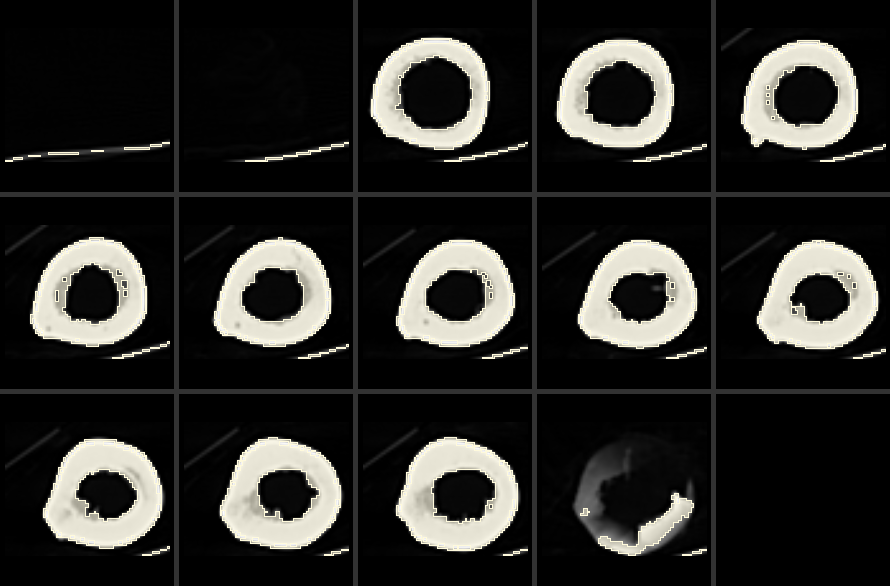

Threshold=32800


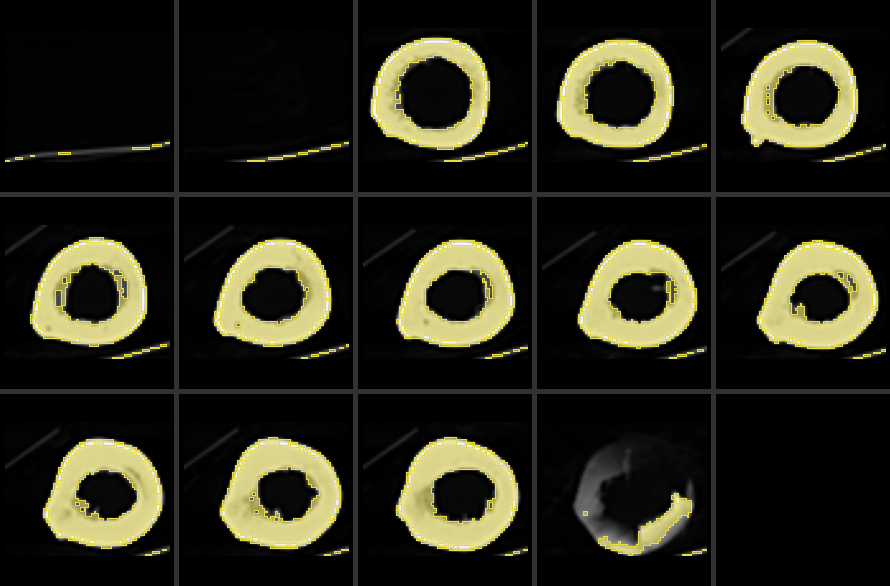

Threshold=32900


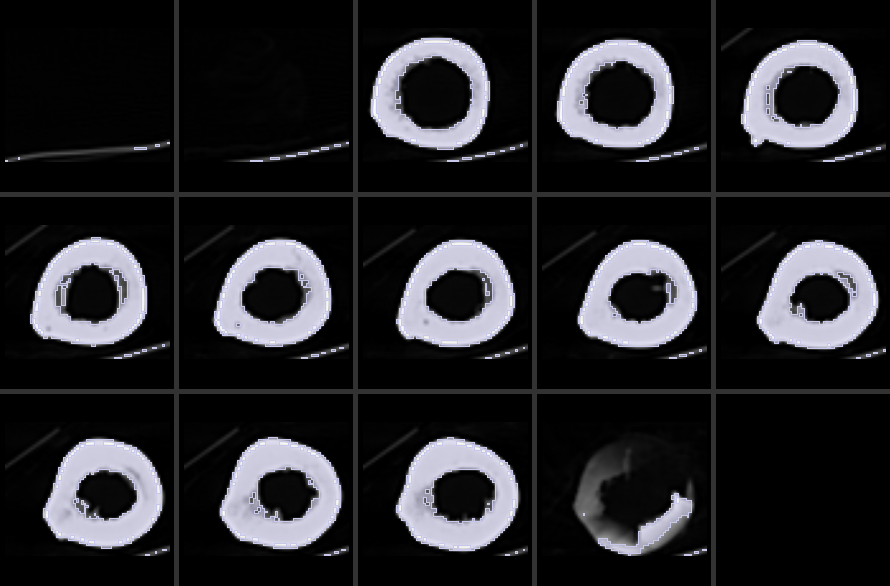

Threshold=33000


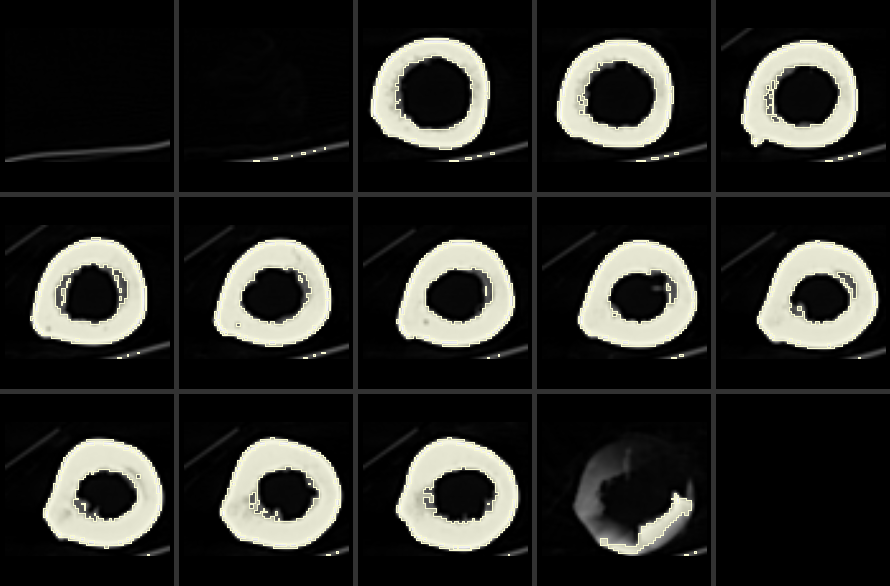

Threshold=33100


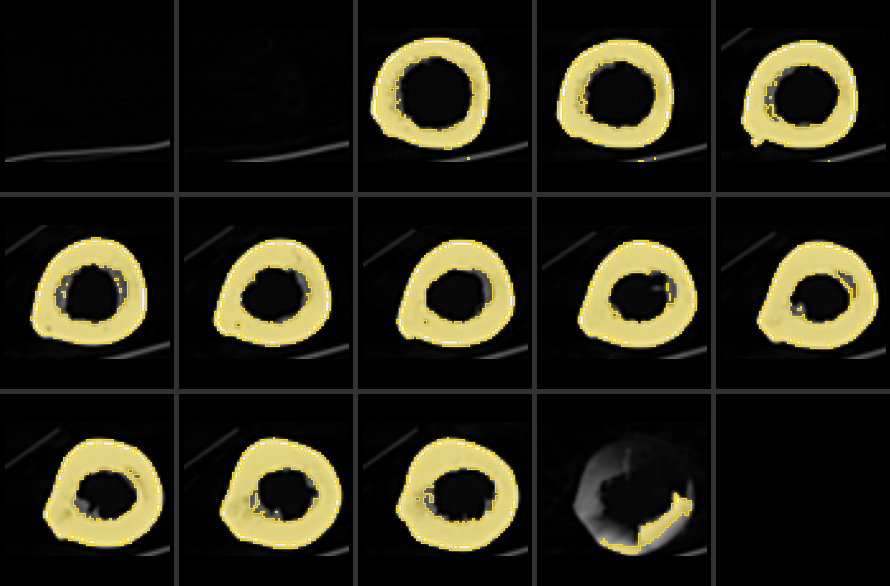

Threshold=33200


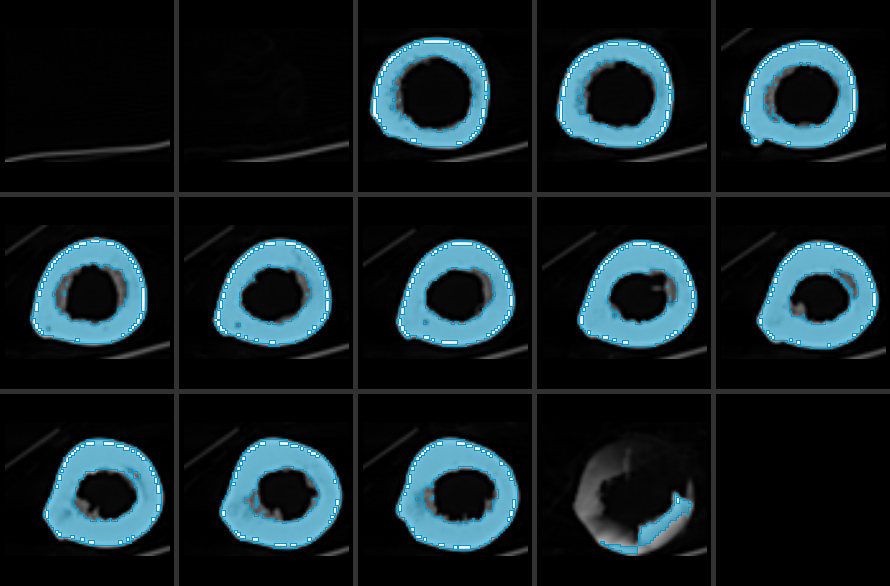

Threshold=33300


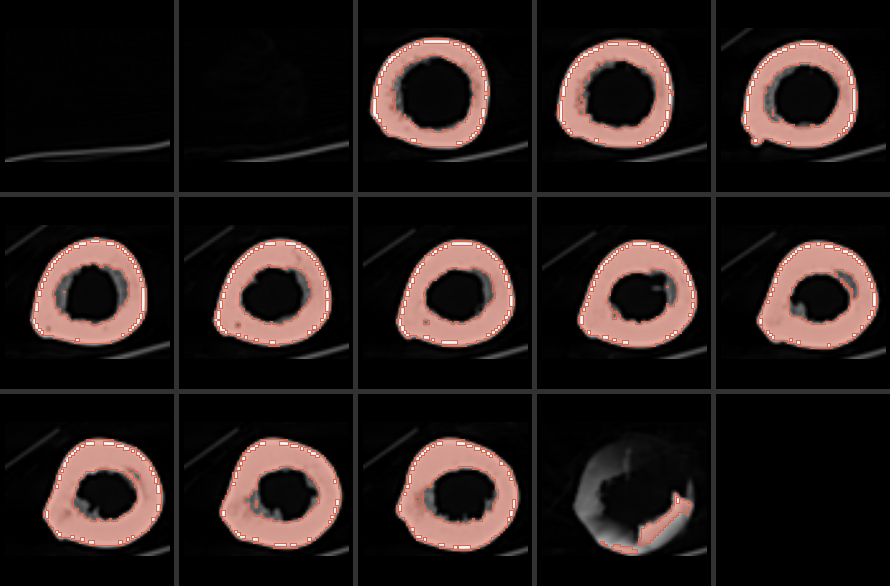

Threshold=33400


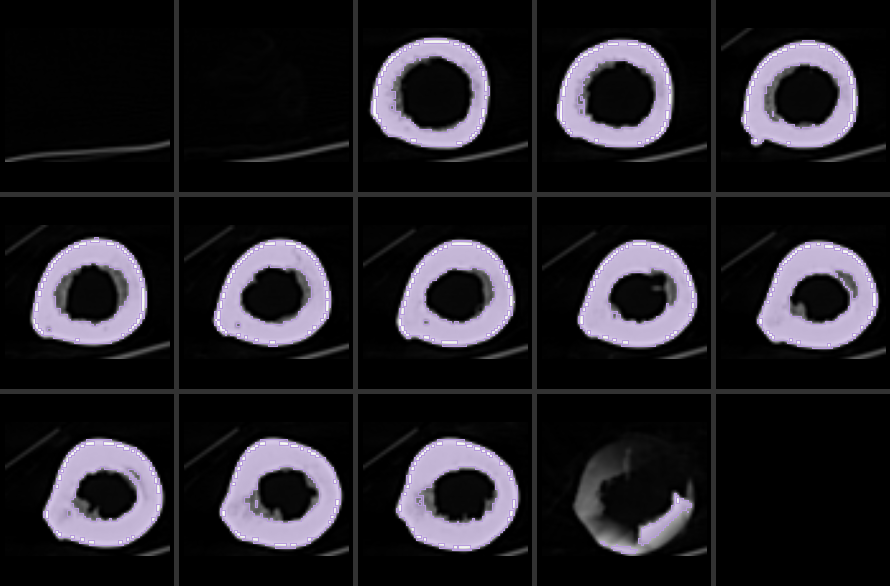

Threshold=33500


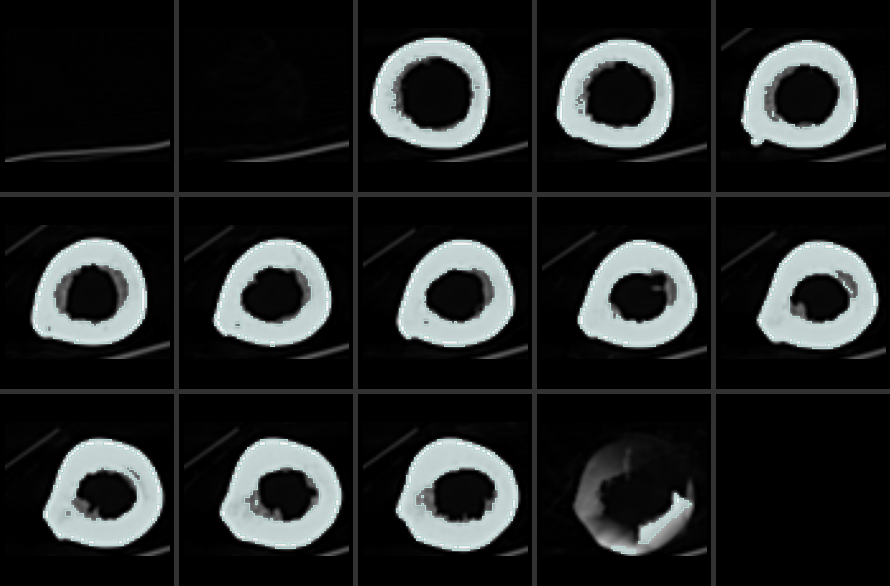

Threshold=33600


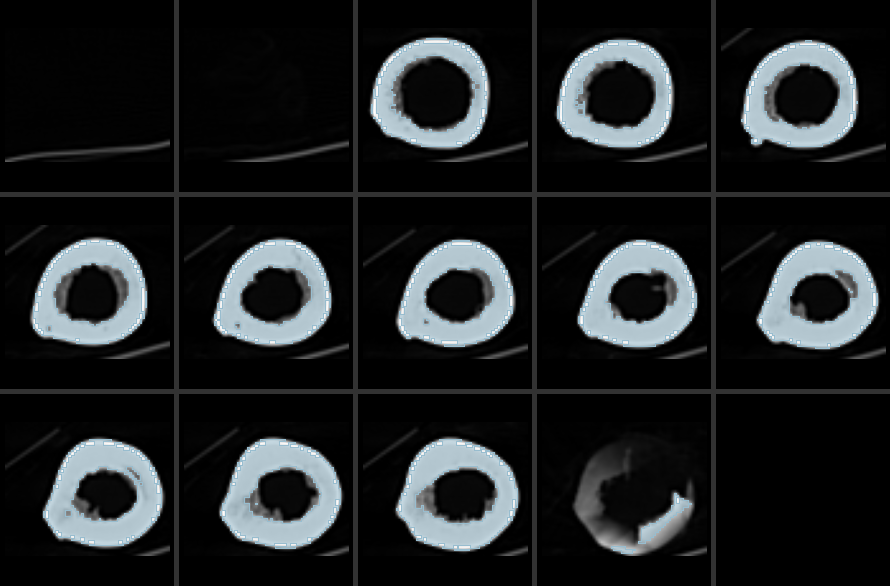

Threshold=33700


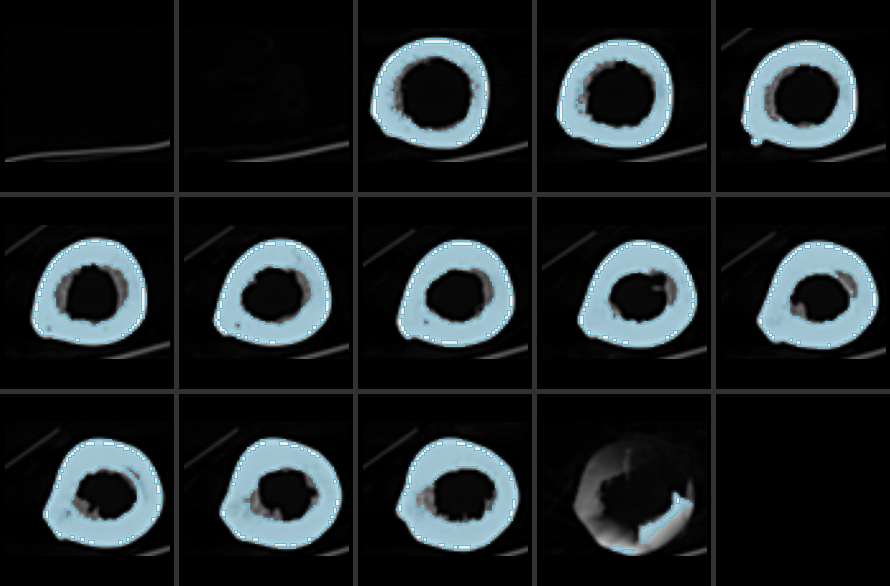

Threshold=33800


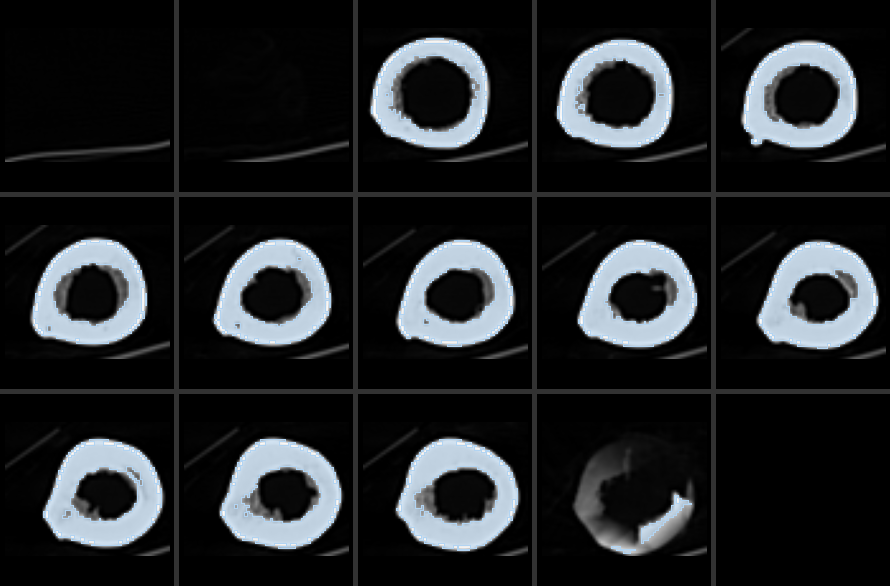

Threshold=33900


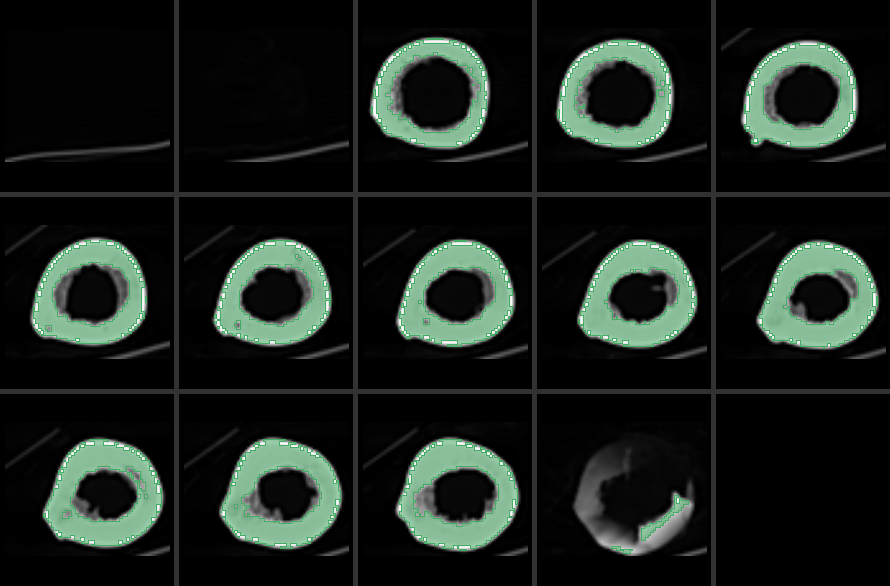

Threshold=34000


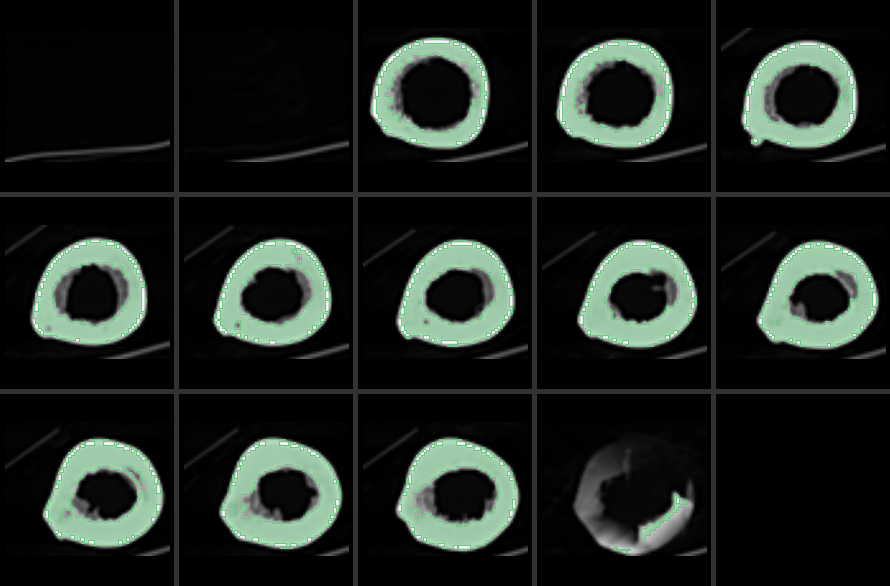

Threshold=34100


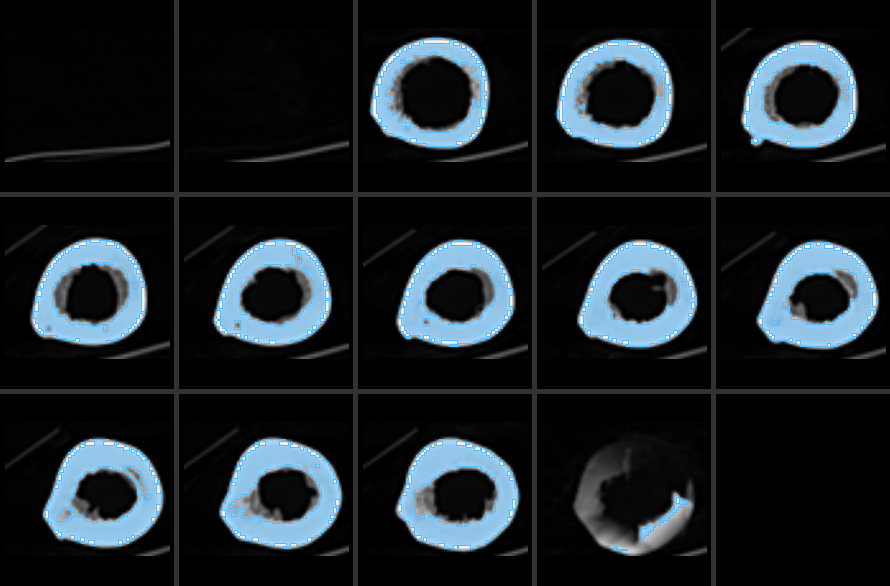

Threshold=34200


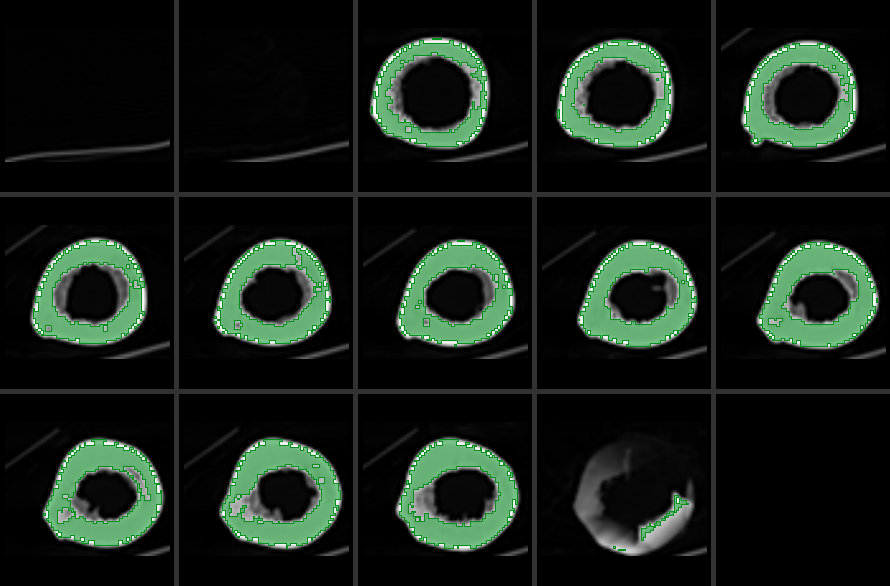

Threshold=34300


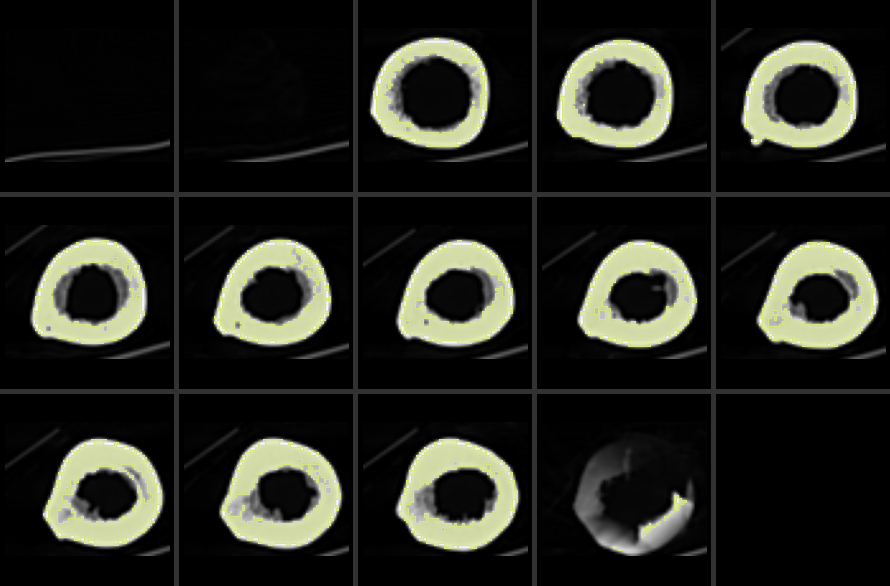

Threshold=34400


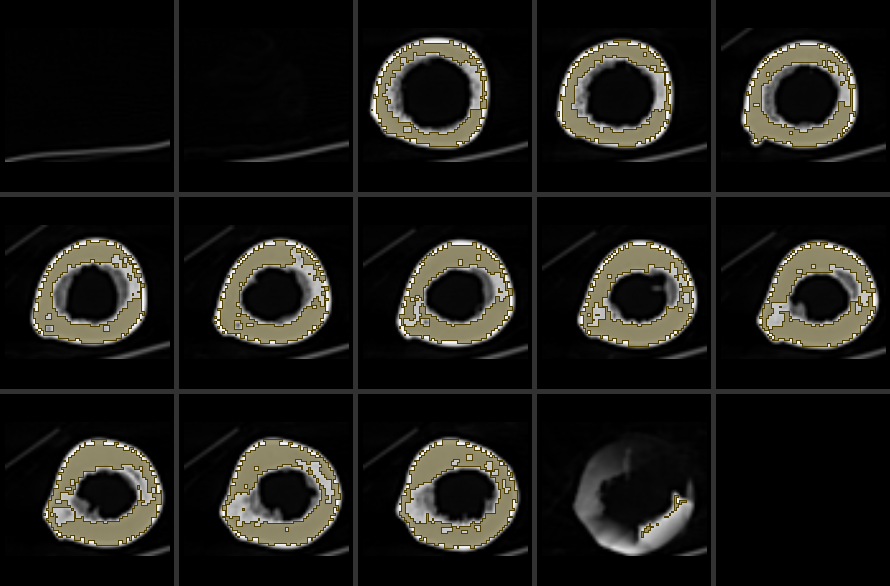

Threshold=34500


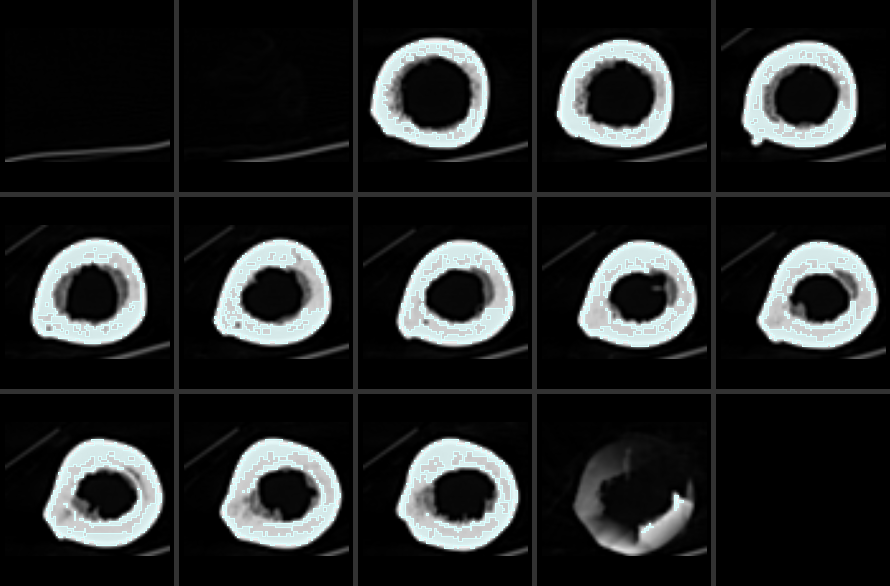

Threshold=34600


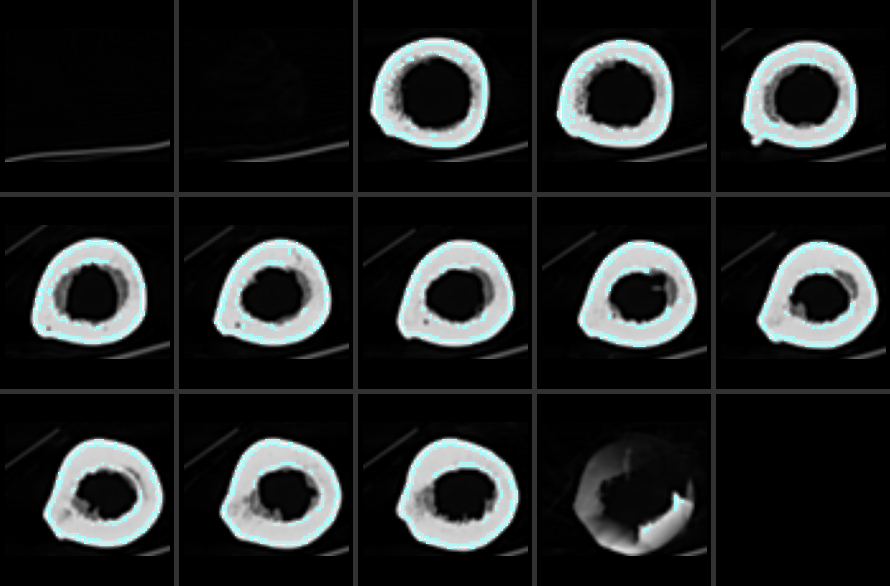

Threshold=34700


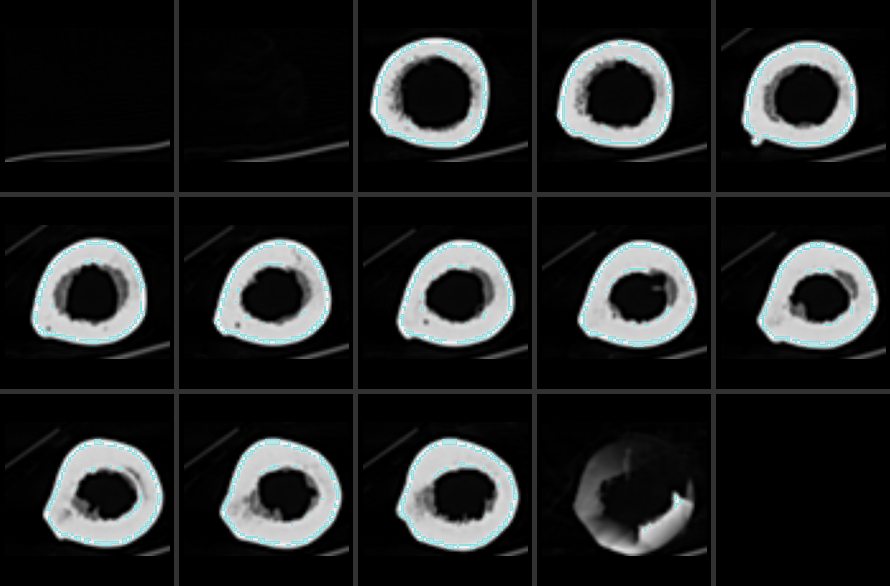

Threshold=34800


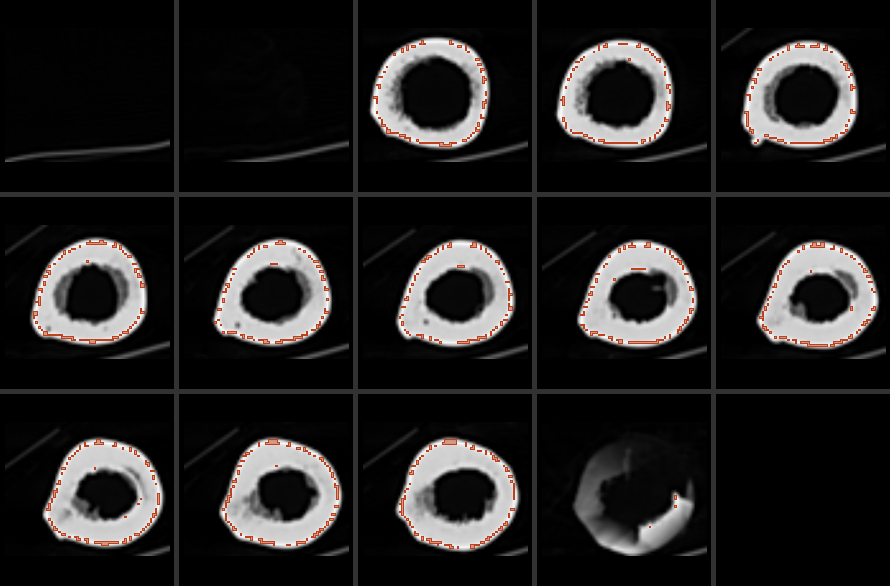

Threshold=34900


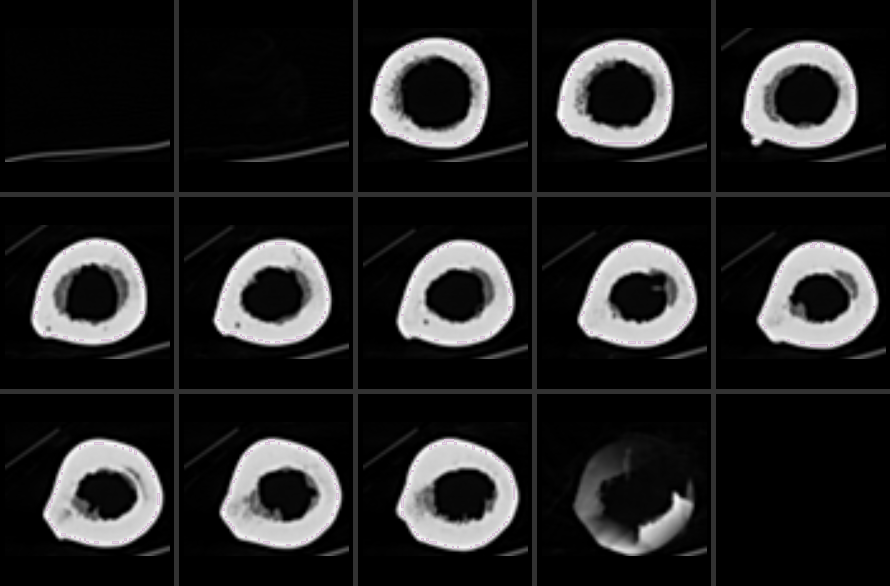

In [4]:
# Create segmentation
segmentationNode = slicer.mrmlScene.AddNewNodeByClass("vtkMRMLSegmentationNode")
segmentationNode.CreateDefaultDisplayNodes() # only needed for display
segmentationNode.SetReferenceImageGeometryParameterFromVolumeNode(volumeNode)

# Create temporary segment editor to get access to segmentation tools
segmentEditorWidget = slicer.qMRMLSegmentEditorWidget()
segmentEditorWidget.setMRMLScene(slicer.mrmlScene)
segmentEditorNode = slicer.mrmlScene.AddNewNodeByClass("vtkMRMLSegmentEditorNode")
segmentEditorWidget.setMRMLSegmentEditorNode(segmentEditorNode)
segmentEditorWidget.setSegmentationNode(segmentationNode)
segmentEditorWidget.setMasterVolumeNode(volumeNode)
segmentEditorNode.SetOverwriteMode(slicer.vtkMRMLSegmentEditorNode.OverwriteNone)

# Create segments by thresholding
import numpy as np
for thresholdLevel in np.arange(thresholdMin, thresholdMax, thresholdStep):
    print(f"Threshold={thresholdLevel}"); slicer.app.processEvents()
    # Create segment
    segmentName = str(thresholdLevel)
    addedSegmentID = segmentationNode.GetSegmentation().AddEmptySegment(segmentName)
    segmentEditorNode.SetSelectedSegmentID(addedSegmentID)
    # Fill by thresholding
    segmentEditorWidget.setActiveEffectByName("Threshold")
    effect = segmentEditorWidget.activeEffect()
    effect.setParameter("MinimumThreshold",str(thresholdLevel))
    effect.setParameter("MaximumThreshold",str(thresholdMax))
    effect.self().onApply()
    # Display segmentation result
    display(slicernb.ViewLightboxDisplay("Red", columns=5, rows=3))
    # Hide segment (so that does not occlude the view for the next display)
    segmentationNode.GetDisplayNode().SetSegmentVisibility(addedSegmentID, False)
    
# Delete temporary segment editor
segmentEditorWidget = None
slicer.mrmlScene.RemoveNode(segmentEditorNode)

# Show all segments
segmentationNode.GetDisplayNode().SetAllSegmentsVisibility(True)

In [5]:
# Compute segment volumes
segmentationNode.GetDisplayNode().SetAllSegmentsVisibility(True)
resultsTableNode = slicer.mrmlScene.AddNewNodeByClass('vtkMRMLTableNode')
import SegmentStatistics
segStatLogic = SegmentStatistics.SegmentStatisticsLogic()
segStatLogic.getParameterNode().SetParameter("Segmentation", segmentationNode.GetID())
segStatLogic.getParameterNode().SetParameter("ScalarVolume", volumeNode.GetID())
segStatLogic.getParameterNode().SetParameter("LabelmapSegmentStatisticsPlugin.enabled","False")
segStatLogic.getParameterNode().SetParameter("ClosedSurfaceSegmentStatisticsPlugin.enabled","False")
segStatLogic.getParameterNode().SetParameter("ScalarVolumeSegmentStatisticsPlugin.voxel_count.enabled","False")
segStatLogic.getParameterNode().SetParameter("ScalarVolumeSegmentStatisticsPlugin.volume_mm3.enabled","False")
segStatLogic.computeStatistics()
segStatLogic.exportToTable(resultsTableNode)
segStatLogic.showTable(resultsTableNode)
# convert segment name column to numeric so that it can be used as x coordinate in scatter plot
import vtk
resultsTableNode.SetColumnType("Segment", vtk.VTK_FLOAT)

# Create plot
plotSeriesNode = slicer.mrmlScene.AddNewNodeByClass("vtkMRMLPlotSeriesNode")
plotSeriesNode.SetAndObserveTableNodeID(resultsTableNode.GetID())
plotSeriesNode.SetXColumnName("Segment")
plotSeriesNode.SetYColumnName("Volume [cm3]")
plotSeriesNode.SetPlotType(plotSeriesNode.PlotTypeScatter)
# Create chart and add plot
plotChartNode = slicer.mrmlScene.AddNewNodeByClass("vtkMRMLPlotChartNode")
plotChartNode.AddAndObservePlotSeriesNodeID(plotSeriesNode.GetID())
# Show plot in layout
slicer.app.layoutManager().setLayout(slicer.vtkMRMLLayoutNode.SlicerLayoutConventionalPlotView)
slicer.modules.plots.logic().ShowChartInLayout(plotChartNode)

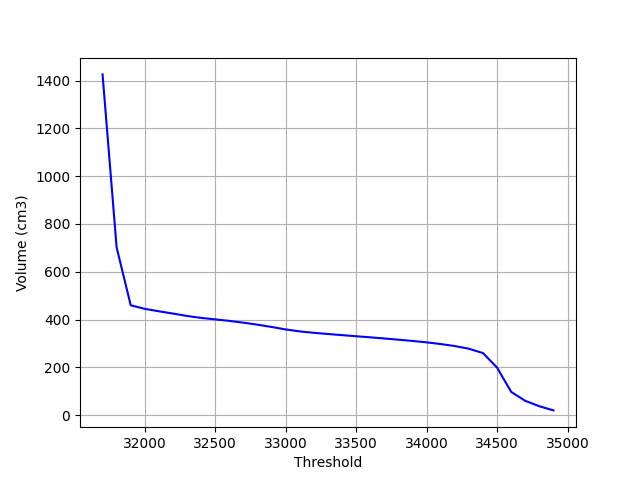

In [6]:
# Display volume-threshold plot using matplotlib
try:
  import matplotlib
except ModuleNotFoundError:
  slicer.util.pip_install("matplotlib")
    
import matplotlib
matplotlib.use("Agg")

import matplotlib.pyplot as plt
plt.plot(slicer.util.arrayFromTableColumn(resultsTableNode, 'Segment'),slicer.util.arrayFromTableColumn(resultsTableNode, 'Volume [cm3]'), "b-")
plt.grid(True)
plt.xlabel("Threshold")
plt.ylabel("Volume (cm3)")
slicernb.display.MatplotlibDisplay(plt)


In [8]:
# Show the full interactive application window (only for binder)

app = slicernb.AppWindow()
slicernb.ViewDisplay("FourUp")
slicer.util.selectModule("Data")
app.setContents("full")
app

In [7]:
# Only recommended to run this locally (processing would take too long on binder)

# Show results in 3D
segmentationNode.GetSegmentation().SetConversionParameter("Smoothing factor","0.0")  # Turn of surface smoothing
segmentationNode.CreateClosedSurfaceRepresentation()
segmentationNode.GetDisplayNode().SetOpacity(0.8)

# Show slice and 3D views
slicernb.AppWindow.setWindowSize(scale=0.7)  # Use a bit larger size, as we'll display 4 views
slicernb.ViewDisplay("OneUp3D")  # You can also try: FourUp, OneUpRedSlice, OneUp3D